# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

41816


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5
import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width,  _ticklabel_size,_ticklabel_width


In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']


sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                   'Sst', 'Sncg', 'Pvalb',
                         'L5/6 NP',
                         'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load chromatin size dataframe

Data below can be generated using the notebook as:

[5_calculate_chromatin_Rg](./5_calculate_chromatin_Rg.ipynb)

In [8]:
df_rg_filename = os.path.join(output_analysis_folder, 'WT_MOp_Rg.csv')

if os.path.exists(df_rg_filename):
    df_rg = pd.read_csv(df_rg_filename, index_col=0)

In [9]:
df_rg.head()

,rg,uid,majorType,subclass,chr,fiberidx
0,1.241714,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr1,1
1,1.163226,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr10,1
2,1.888276,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr11,1
3,1.759560,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr12,1
4,1.404082,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr13,1


## Plot

In [10]:
chroms = []
for i in range(1,20):
    chroms.append('chr'+str(i))
chroms.append('chrX')
    
#majorTypes = ['Gluta', 'GABA', 'Astro', 'Oligo', 'Micro', 'Endo']
dict_mean_rg = {}

for cls in sorted_cellplot_order:
    dict_mean_rg[cls] = []
    for chrom in chroms:
        _rgs = df_rg[(df_rg.subclass==cls)&(df_rg.chr==chrom)]['rg'].values
        dict_mean_rg[cls].append(np.median(_rgs))

df_mean_rg = pd.DataFrame(dict_mean_rg, index=chroms)

In [11]:
df_mean_rg = df_mean_rg.transpose()
df_mean_rg

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chrX
Micro,1.265197,1.277479,1.201212,1.207304,1.181272,1.158373,1.103732,1.135572,1.140349,1.149966,1.210052,1.088173,1.140797,1.147000,1.171639,1.127177,1.088523,1.061352,1.051862,1.184527
Oligo,1.322090,1.313591,1.254269,1.256475,1.276547,1.217699,1.202987,1.198813,1.188059,1.179795,1.285470,1.173393,1.173477,1.177824,1.261322,1.181396,1.120529,1.072052,1.085284,1.280247
Endo,1.391142,1.366697,1.294861,1.324216,1.300087,1.265530,1.181325,1.192193,1.206204,1.217261,1.275385,1.172342,1.197313,1.206640,1.235560,1.208489,1.113623,1.103111,1.046080,1.255402
OPC,1.533785,1.555560,1.464405,1.445867,1.448314,1.396994,1.394840,1.359072,1.416134,1.385897,1.475322,1.324982,1.327554,1.369774,1.397447,1.345881,1.247117,1.230678,1.248422,1.322279
Astro,1.427638,1.428162,1.338827,1.363137,1.357359,1.308634,1.318593,1.306639,1.343185,1.276448,1.464072,1.256390,1.245195,1.278429,1.349533,1.286322,1.187235,1.147512,1.166634,1.325159
Vip,1.643939,1.658725,1.623956,1.708038,1.679604,1.565421,1.565848,1.517714,1.620129,1.554633,1.557614,1.481383,1.531442,1.514302,1.525699,1.518442,1.579445,1.452523,1.434923,1.479670
Lamp5,1.547160,1.516930,1.481616,1.542194,1.540327,1.455595,1.457149,1.438814,1.492443,1.441063,1.478155,1.391901,1.390047,1.401440,1.380030,1.407653,1.421076,1.298400,1.333799,1.360623
Sst,1.620192,1.590591,1.550936,1.613544,1.592114,1.488714,1.534679,1.481261,1.515117,1.502107,1.504964,1.471130,1.454773,1.472791,1.448032,1.508142,1.473777,1.363348,1.369537,1.409436
Sncg,1.726148,1.626284,1.646635,1.658600,1.687807,1.577602,1.610249,1.610501,1.730330,1.615130,1.568401,1.569864,1.615119,1.522789,1.565907,1.475808,1.531002,1.445585,1.420770,1.406271
Pvalb,1.719844,1.678128,1.673002,1.706517,1.711863,1.579307,1.630449,1.610988,1.611072,1.602072,1.609795,1.545025,1.548318,1.547367,1.556592,1.576492,1.593132,1.449824,1.459564,1.436795


In [25]:
chrom_ticks = []
for i in range(1,20):
    chrom_ticks.append(str(i))
chrom_ticks.append('X')

xticks = []
for i in range(20):
    xticks.append(i+0.5)

meta NOT subset; don't know how to subset; dropped


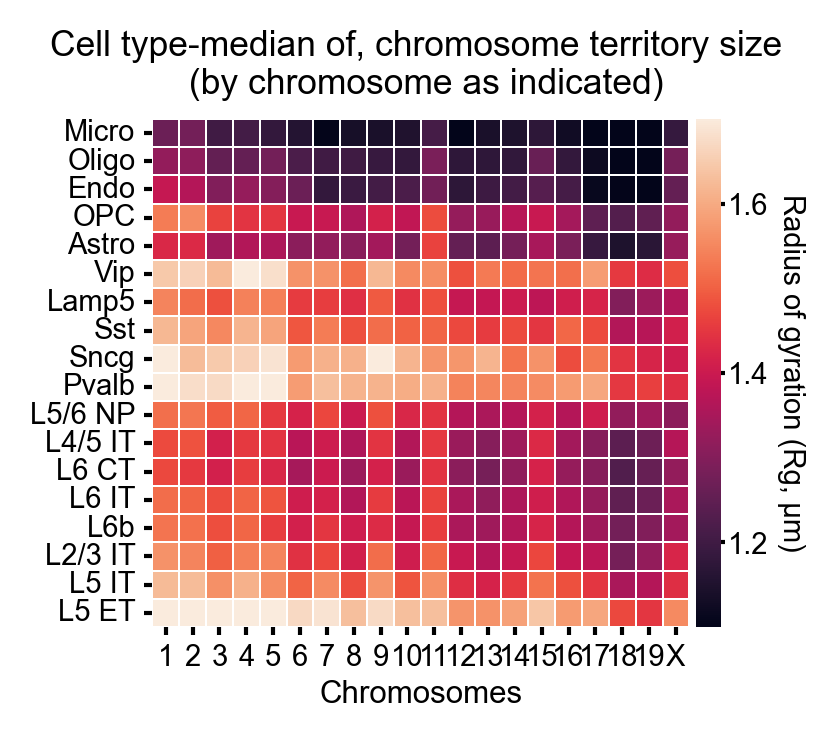

In [52]:
%matplotlib inline
fig = plt.figure(figsize=(_page_width/2,_page_width/2.5), dpi=300)
ax = sns.heatmap(data=df_mean_rg, vmin=1.1, vmax=1.7, annot=False, 
                 cbar_kws={#'label':'correlation', 
                     "pad": 0.01,},
                 linewidth=.01)

ax.set_xticks(xticks, chrom_ticks, fontsize=7, rotation='horizontal')
ax.set_xlabel('Chromosomes', fontsize=7.5, labelpad=2)
ax.tick_params(axis='both', length=2, pad=2)
ax.set_yticks(ticks = np.arange(len(sorted_cellplot_order))+0.5)
ax.set_yticklabels(labels=sorted_cellplot_order, fontsize=7, rotation='horizontal')
ax.figure.axes[-1].yaxis.label.set_size(7)
ax.figure.axes[-1].set_yticks([1.2,1.4,1.6],[1.2,1.4,1.6],fontsize=_font_size-0.5)
ax.figure.axes[-1].tick_params(axis='both', length=1, pad=0.5)
ax.figure.axes[-1].set_ylabel('Radius of gyration (Rg, \u03BCm)', fontsize=_font_size-0.5, rotation=270, labelpad=9)
ax.set_title('Cell type-median of, chromosome territory size \n (by chromosome as indicated)')
figure_file = os.path.join(output_figure_folder, 'subclass_chromosome_Rg.pdf')
plt.savefig(figure_file,
                    transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.savefig(figure_file.replace('.pdf', '.png'),
            transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)

plt.show()

# 3. Load chromosome segregation score

Data below can be generated using the notebook as:

[6_calculate_chrom_insulation](6_calculate_chrom_insulation.ipynb)

In [41]:
df_seg_filename = os.path.join(output_analysis_folder, 'WT_MOp_insulation_average.csv')

if os.path.exists(df_seg_filename):
    df_seg = pd.read_csv(df_seg_filename, index_col=0)

In [42]:
df_seg.head()

,uid,majorType,subclass,chr,mean_insulation_score
0,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr1,2.595337
1,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr2,2.609158
2,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr3,2.274567
3,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr5,2.571502
4,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr7,2.239924


## Plot

In [43]:
chroms = []
for i in range(1,20):
    chroms.append('chr'+str(i))
chroms.append('chrX')
    
#majorTypes = ['Gluta', 'GABA', 'Astro', 'Oligo', 'Micro', 'Endo']
dict_mean_seg = {}

for cls in sorted_cellplot_order:
    dict_mean_seg[cls] = []
    for chrom in chroms:
        _segs = df_seg[(df_seg.subclass==cls)&(df_seg.chr==chrom)]['mean_insulation_score'].values
        dict_mean_seg[cls].append(np.median(_segs))

df_mean_seg = pd.DataFrame(dict_mean_seg, index=chroms)

In [44]:
df_mean_seg = df_mean_seg.transpose()
df_mean_seg

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chrX
Micro,2.469520,2.436179,2.596172,2.520894,2.522812,2.630691,2.540109,2.582812,2.548109,2.630679,2.288421,2.663273,2.588384,2.606606,2.537341,2.611846,2.573655,2.713996,2.439446,2.741652
Oligo,2.410584,2.375107,2.522073,2.398981,2.367481,2.540887,2.388854,2.533803,2.379590,2.555402,2.221029,2.543844,2.554066,2.515023,2.424024,2.548055,2.474602,2.601516,2.344090,2.635512
Endo,2.164467,2.136121,2.280864,2.199363,2.202755,2.285463,2.321792,2.317018,2.288532,2.338814,2.140113,2.333990,2.313908,2.311770,2.249091,2.334091,2.324072,2.395766,2.330001,2.432774
OPC,2.224542,2.167684,2.317403,2.213959,2.203130,2.329101,2.226826,2.328925,2.246477,2.347586,2.177799,2.323911,2.372685,2.329328,2.287551,2.312115,2.367463,2.411951,2.301537,2.542041
Astro,2.208273,2.182628,2.361228,2.235120,2.272138,2.377532,2.259831,2.310126,2.191991,2.387435,2.077666,2.336349,2.337314,2.359140,2.230983,2.284654,2.328333,2.409334,2.228523,2.457327
Vip,2.155119,2.225054,2.259318,2.102453,2.068157,2.216144,2.159205,2.256369,2.224938,2.275388,2.201037,2.259206,2.248485,2.295729,2.263935,2.258714,2.174512,2.337389,2.206741,2.436886
Lamp5,2.382574,2.436745,2.552450,2.360792,2.323694,2.477415,2.297746,2.521189,2.392209,2.514587,2.470975,2.509467,2.485994,2.519293,2.460310,2.496547,2.300134,2.601476,2.433129,2.643383
Sst,2.416629,2.353882,2.479366,2.353503,2.331303,2.498154,2.306750,2.472646,2.371020,2.497495,2.425799,2.432174,2.503529,2.509610,2.466073,2.365273,2.316470,2.549488,2.433267,2.574539
Sncg,2.303569,2.409114,2.373640,2.242850,2.255865,2.303629,2.289291,2.366912,2.326142,2.288987,2.331057,2.199915,2.302088,2.311090,2.313441,2.358026,2.322438,2.404685,2.301063,2.507583
Pvalb,2.326473,2.325434,2.386133,2.268624,2.276072,2.416645,2.212418,2.360235,2.317073,2.411576,2.342133,2.393589,2.434158,2.468815,2.384506,2.333016,2.269517,2.499049,2.359154,2.535840


In [45]:
sel_sorted_cellplot_order = ['Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

sel_sorted_cellplot_order = sorted_cellplot_order

sel_df_mean_seg = df_mean_seg[df_mean_seg.index.isin(sel_sorted_cellplot_order)]

In [46]:
chrom_ticks = []
for i in range(1,20):
    chrom_ticks.append(str(i))
chrom_ticks.append('X')

xticks = []
for i in range(20):
    xticks.append(i+0.5)

meta NOT subset; don't know how to subset; dropped


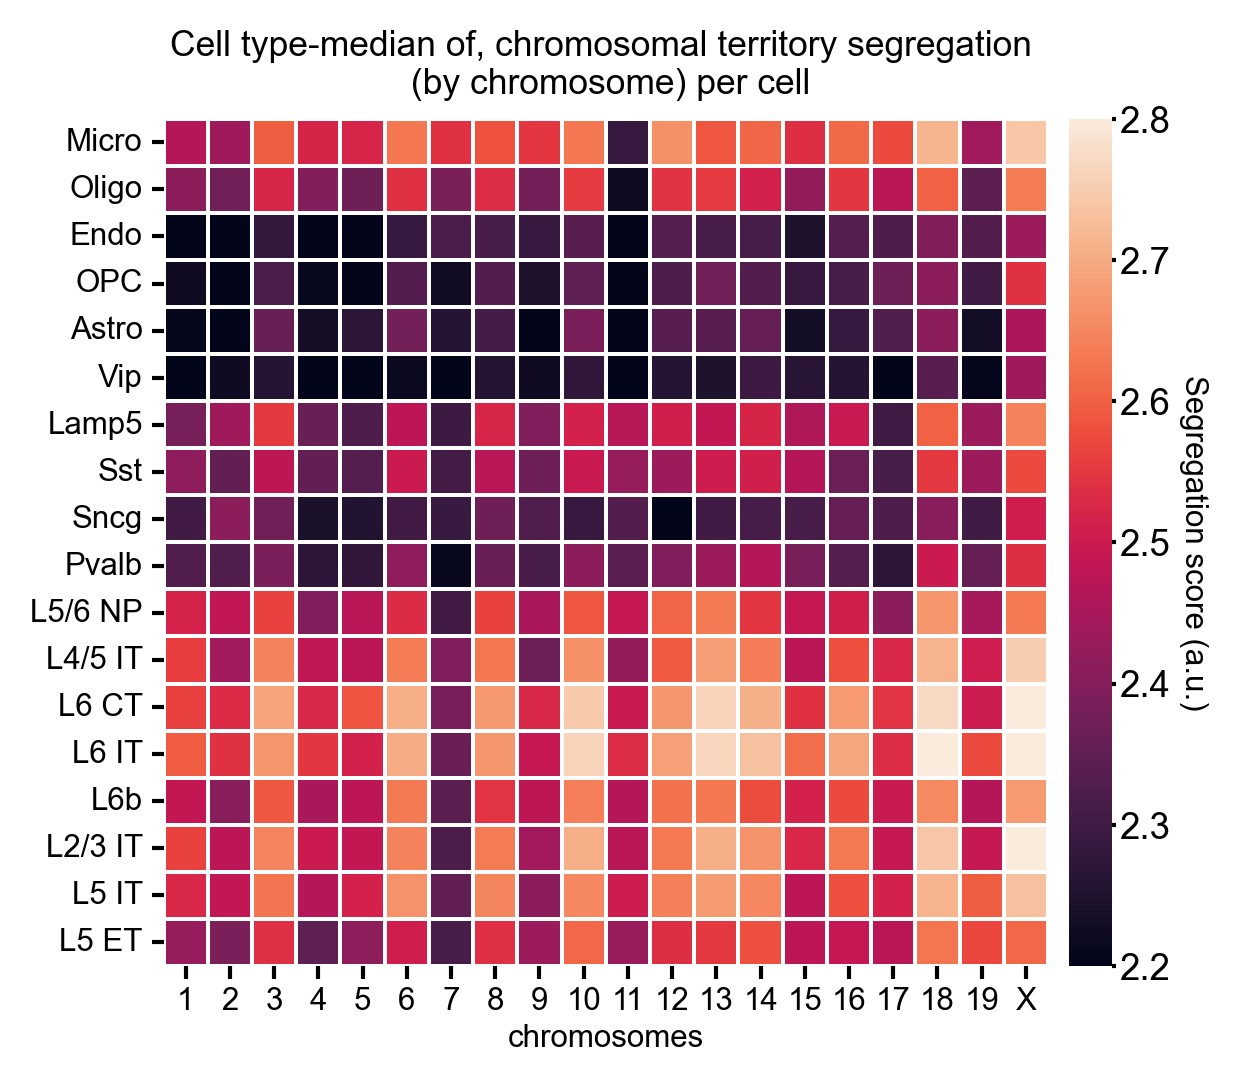

In [50]:
%matplotlib inline
fig = plt.figure(figsize=(_page_width/1.2,_page_width/1.5), dpi=300)

vmin, vmax =2.2, 2.8

ax = sns.heatmap(data=sel_df_mean_seg, vmin=vmin, vmax=vmax, annot=False, 
                                  cbar_kws={#'label':'correlation', 
                     "pad": 0.02,},
                 linewidth=.5)

ax.set_xticks(xticks, chrom_ticks, fontsize=_font_size, rotation='horizontal')
ax.set_xlabel('chromosomes', fontsize=_font_size, labelpad=2)
ax.tick_params(axis='both', length=3, pad=2)
ax.set_yticklabels(labels=sel_sorted_cellplot_order, fontsize=_font_size, rotation='horizontal')
ax.figure.axes[-1].yaxis.label.set_size(7)
#ax.figure.axes[-1].set_yticks([vmin,round((vmax-vmin)/2,1),vmax],[vmin,round((vmin+vmax)/2,1),vmax],fontsize=7)
ax.figure.axes[-1].tick_params(axis='y', length=1, pad=1)
ax.figure.axes[-1].set_ylabel('Segregation score (a.u.)', fontsize=_font_size, rotation=270, labelpad=9)
ax.set_title('Cell type-median of, chromosomal territory segregation \n (by chromosome) per cell')

figure_file = os.path.join(output_figure_folder, 'subclass_chromosome_segregation_score.pdf')
plt.savefig(figure_file,
                    transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.savefig(figure_file.replace('.pdf', '.png'),
            transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)

plt.show()